In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import framework
import utils

In [2]:
DEBUG = False

In [3]:
GAMMA = 0.5  # discounted factor
TRAINING_EP = 0.5  # epsilon-greedy parameter for training
TESTING_EP = 0.05  # epsilon-greedy parameter for testing
NUM_RUNS = 10
NUM_EPOCHS = 600
NUM_EPIS_TRAIN = 25  # number of episodes for training at each epoch
NUM_EPIS_TEST = 50  # number of episodes for testing
ALPHA = 0.001  # learning rate for training

ACTIONS = framework.get_actions()
OBJECTS = framework.get_objects()
NUM_ACTIONS = len(ACTIONS)
NUM_OBJECTS = len(OBJECTS)

In [4]:
def tuple2index(action_index, object_index):
    """Converts a tuple (a,b) to an index c"""
    return action_index * NUM_OBJECTS + object_index


def index2tuple(index):
    """Converts an index c to a tuple (a,b)"""
    return index // NUM_OBJECTS, index % NUM_OBJECTS


In [5]:
def epsilon_greedy(state_vector, theta, epsilon):
    """Returns an action selected by an epsilon-greedy exploration policy

    Args:
        state_vector (np.ndarray): extracted vector representation
        theta (np.ndarray): current weight matrix
        epsilon (float): the probability of choosing a random command

    Returns:
        (int, int): the indices describing the action/object to take
    """
    if np.random.binomial(1, epsilon):
        # Randomly choose action and object
        action_index, object_index = np.random.randint(NUM_ACTIONS, size=1), \
                                    np.random.randint(NUM_OBJECTS, size=1)
    else:
        # Choose the best action and object
        action_index, object_index = np.unravel_index(np.argmax(theta @ state_vector),
                                                      (NUM_ACTIONS, NUM_OBJECTS))
        
    return (int(action_index), int(object_index))

    # TODO Your code here
    #action_index, object_index = None, None
    #return (action_index, object_index)
# pragma: coderesponse end


In [6]:
def linear_q_learning(theta, current_state_vector, action_index, object_index,
                      reward, next_state_vector, terminal):
    """Update theta for a given transition

    Args:
        theta (np.ndarray): current weight matrix
        current_state_vector (np.ndarray): vector representation of current state
        action_index (int): index of the current action
        object_index (int): index of the current object
        reward (float): the immediate reward the agent recieves from playing current command
        next_state_vector (np.ndarray): vector representation of next state
        terminal (bool): True if this epsiode is over

    Returns:
        None
    """
    if terminal:
        maxQ = 0.0
    else:
        maxQ = np.max(theta @ next_state_vector)
    
    # Q(s, c, theta) for current command, c
    Q_val = (theta @ current_state_vector)[tuple2index(action_index, object_index)]
    
    # y = R(s, c) + gamma*maxQ
    y = reward + GAMMA*maxQ
    
    theta[tuple2index(action_index, object_index)] = \
        theta[tuple2index(action_index, object_index)] + \
        ALPHA*(y - Q_val)*current_state_vector
    
# pragma: coderesponse end

In [7]:
def run_episode(for_training):
    """ Runs one episode
    If for training, update Q function
    If for testing, computes and return cumulative discounted reward

    Args:
        for_training (bool): True if for training

    Returns:
        None
    """
    epsilon = TRAINING_EP if for_training else TESTING_EP
    
    epi_reward = 0.0 # initialize for each episode

    (current_room_desc, current_quest_desc, terminal) = framework.newGame()

    while not terminal:
        # Choose next action and execute
        current_state = current_room_desc + current_quest_desc
        current_state_vector = utils.extract_bow_feature_vector(
            current_state, dictionary)

        next_action_index, next_object_index = epsilon_greedy(current_state_vector, 
                                                              theta, 
                                                              epsilon) # Get next action, object
        
        next_room_desc, next_quest_desc, reward, terminal = framework.step_game(
                                                            current_room_desc,
                                                            current_quest_desc,
                                                            next_action_index,
                                                            next_object_index) # Take a step
        
        next_state = next_room_desc + next_quest_desc   # Build next state vector
        next_state_vector = utils.extract_bow_feature_vector(next_state, dictionary)      

        if for_training:
            # update Q-function.
            linear_q_learning(theta, current_state_vector, next_action_index, 
                          next_object_index, reward, next_state_vector, terminal) # Update theta

        if not for_training:
            # update reward
            epi_reward += (GAMMA**(framework.STEP_COUNT - 1))*reward

        # prepare next step
        current_room_desc, current_quest_desc = next_room_desc, next_quest_desc

    if not for_training:
        return epi_reward


In [8]:
def run_epoch():
    """Runs one epoch and returns reward averaged over test episodes"""
    rewards = []

    for _ in range(NUM_EPIS_TRAIN):
        run_episode(for_training=True)

    for _ in range(NUM_EPIS_TEST):
        rewards.append(run_episode(for_training=False))

    return np.mean(np.array(rewards))

In [9]:
def run():
    """Returns array of test reward per epoch for one run"""
    global theta
    theta = np.zeros([action_dim, state_dim])

    single_run_epoch_rewards_test = []
    pbar = tqdm(range(NUM_EPOCHS), ncols=80)
    for _ in pbar:
        single_run_epoch_rewards_test.append(run_epoch())
        pbar.set_description(
            "Avg reward: {:0.6f} | Ewma reward: {:0.6f}".format(
                np.mean(single_run_epoch_rewards_test),
                utils.ewma(single_run_epoch_rewards_test)))
    return single_run_epoch_rewards_test


Avg reward: 0.246080 | Ewma reward: 0.289486: 100%|█| 600/600 [00:44<00:00, 13.3
Avg reward: 0.253024 | Ewma reward: 0.311680: 100%|█| 600/600 [00:43<00:00, 13.7
Avg reward: 0.248206 | Ewma reward: 0.320518: 100%|█| 600/600 [00:45<00:00, 13.2
Avg reward: 0.267823 | Ewma reward: 0.368403: 100%|█| 600/600 [00:41<00:00, 14.3
Avg reward: 0.260110 | Ewma reward: 0.331046: 100%|█| 600/600 [00:45<00:00, 13.3
Avg reward: 0.253566 | Ewma reward: 0.348123: 100%|█| 600/600 [00:42<00:00, 13.9
Avg reward: 0.250707 | Ewma reward: 0.344688: 100%|█| 600/600 [00:41<00:00, 14.4
Avg reward: 0.257303 | Ewma reward: 0.339318: 100%|█| 600/600 [00:39<00:00, 15.0
Avg reward: 0.261965 | Ewma reward: 0.348180: 100%|█| 600/600 [00:40<00:00, 14.6
Avg reward: 0.257743 | Ewma reward: 0.359938: 100%|█| 600/600 [00:40<00:00, 14.9


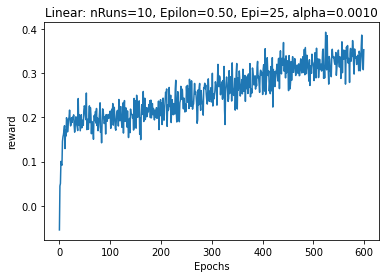

In [10]:
if __name__ == '__main__':
    state_texts = utils.load_data('game.tsv')
    dictionary = utils.bag_of_words(state_texts)
    state_dim = len(dictionary)
    action_dim = NUM_ACTIONS * NUM_OBJECTS

    # set up the game
    framework.load_game_data()

    epoch_rewards_test = []  # shape NUM_RUNS * NUM_EPOCHS

    for _ in range(NUM_RUNS):
        epoch_rewards_test.append(run())

    epoch_rewards_test = np.array(epoch_rewards_test)

    x = np.arange(NUM_EPOCHS)
    fig, axis = plt.subplots()
    axis.plot(x, np.mean(epoch_rewards_test,
                         axis=0))  # plot reward per epoch averaged per run
    axis.set_xlabel('Epochs')
    axis.set_ylabel('reward')
    axis.set_title(('Linear: nRuns=%d, Epilon=%.2f, Epi=%d, alpha=%.4f' %
                    (NUM_RUNS, TRAINING_EP, NUM_EPIS_TRAIN, ALPHA)))